In [14]:
# import all needed libraries
import pandas as pd
import numpy as np
import numpy.random as nr
import sys
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.model_selection as ms
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import feature_selection as fs

from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV

In [15]:
# load the cleaned dataset
lagged_data = pd.read_csv(r'/Users/frederikbomheuer/Desktop/1.Semester/MachineLearing/Project/CO2/data/Lagged_Data.csv')


In [16]:
lagged_data.head()

,country,year,clean_fuel_access_perc,elec_access_perc,nat_res_depl_perc,forest_depl_perc,agri_land_perc,agri_forest_fish_val_perc,co2_emissions_per_capita,cooling_degree_days,...,unemployment_total_perc_lag_1,unemployment_total_perc_lag_2,unemployment_total_perc_lag_3,unemployment_total_perc_lag_4,unemployment_total_perc_lag_5,co2_emissions_per_capita_lag_1,co2_emissions_per_capita_lag_2,co2_emissions_per_capita_lag_3,co2_emissions_per_capita_lag_4,co2_emissions_per_capita_lag_5
0,Albania,2005,52.0,99.371124,0.449098,0.047032,39.306569,18.845309,1.360092,539.51,...,16.31,16.989,17.895,18.575,19.028,1.427944,1.361159,1.233002,1.056868,1.031568
1,Albania,2006,54.8,99.389366,0.533187,0.052604,40.875912,17.708354,1.363989,635.92,...,15.97,16.310,16.989,17.895,18.575,1.360092,1.427944,1.361159,1.233002,1.056868
2,Albania,2007,57.8,99.428452,0.842154,0.072742,40.839416,17.153620,1.433797,828.68,...,15.63,15.970,16.310,16.989,17.895,1.363989,1.360092,1.427944,1.361159,1.233002
3,Albania,2008,60.7,100.000000,0.781658,0.069364,43.102190,16.837054,1.428250,764.05,...,15.97,15.630,15.970,16.310,16.989,1.433797,1.363989,1.360092,1.427944,1.361159
4,Albania,2009,63.1,99.554451,0.492035,0.076017,43.843066,16.794384,1.492117,706.45,...,13.06,15.970,15.630,15.970,16.310,1.428250,1.433797,1.363989,1.360092,1.427944


In [25]:
# Create dummy variables for each country
data_with_dummies = pd.get_dummies(lagged_data, columns=['country'], prefix='', prefix_sep='')

In [26]:
data_with_dummies.head()

,clean_fuel_access_perc,elec_access_perc,nat_res_depl_perc,forest_depl_perc,agri_land_perc,agri_forest_fish_val_perc,co2_emissions_per_capita,cooling_degree_days,energy_intensity_primary_energy,fertility_rate,...,United Arab Emirates,United Kingdom,United States,Uruguay,Uzbekistan,"Venezuela, RB",Viet Nam,"Yemen, Rep.",Zambia,Zimbabwe
year,,,,,,,,,,,,,,,,,,,,,
2007,100.0,100.000000,0.331826,0.000000,64.803035,3.486557,5.355169,832.52,4.44,1.320,...,False,False,False,False,False,False,False,False,False,False
2007,23.3,31.104935,4.579793,1.346549,57.497896,35.667514,0.447880,5936.84,3.33,5.065,...,False,False,False,False,False,False,False,False,False,False
2007,1.1,17.499512,6.499775,6.499723,70.318465,28.067013,0.086479,3040.43,5.58,4.997,...,False,False,False,False,False,False,False,False,False,False
2007,3.4,28.010048,0.001027,0.000000,29.709117,26.971087,0.462339,6047.93,5.91,5.563,...,False,False,False,False,False,False,False,False,False,False
2007,100.0,100.000000,0.021416,0.016355,50.884457,0.363223,23.155338,74.88,3.05,1.610,...,False,False,False,False,False,False,False,False,False,False


In [17]:
from sklearn.model_selection import TimeSeriesSplit 

tss = TimeSeriesSplit(n_splits=4)

lagged_data.set_index('year', inplace=True)
lagged_data.sort_index(inplace=True)

# Create lagged variables for CO2 emissions per capita
lagged_data['co2_emissions_per_capita_lag1'] = lagged_data.groupby('country')['co2_emissions_per_capita'].shift(1)
lagged_data['co2_emissions_per_capita_lag2'] = lagged_data.groupby('country')['co2_emissions_per_capita'].shift(2)

# Drop rows with NaN values created by lag features
lagged_data.dropna(inplace=True)

X = lagged_data.drop(labels=['co2_emissions_per_capita'], axis=1)
y = lagged_data['co2_emissions_per_capita']

In [18]:
# train test split for a time series dataset
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

Text(0.5, 1.0, 'Mean CO2 Emissions per Capita by Year')

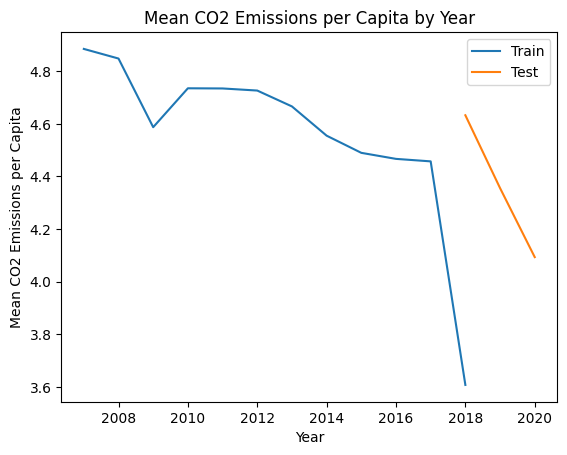

In [19]:
# Plot the mean CO2 emissions per capita by year for train and test sets
y_train.groupby('year').mean().plot(label='Train', legend=True)
y_test.groupby('year').mean().plot(label='Test', legend=True)

plt.xlabel('Year')
plt.ylabel('Mean CO2 Emissions per Capita')
plt.title('Mean CO2 Emissions per Capita by Year')

In [20]:
from sklearn.metrics import mean_squared_error

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

ValueError: could not convert string to float: 'Hungary'

In [ ]:
# Forecasting the next 5 years
# Assuming you have the features for the next 5 years in X_future
# You need to create X_future with the same number of features as X_train

# Example: Creating a dummy X_future with the same number of features
# Replace this with your actual future data
num_features = X_train.shape[1]
X_future = np.random.rand(5, num_features)  # 5 future data points with the same number of features

# Ensure X_future is in the correct shape
X_future = X_future.reshape(-1, num_features)

y_future_pred = model.predict(X_future)
print(f'Forecasted CO2 Emissions per Capita for the next 5 years: {y_future_pred}')

AttributeError: 'RandomForestRegressor' object has no attribute 'estimators_'